# LSTM实现网购评论的对象分类

In [2]:
import re
import json
import jieba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score
import torch
from torch import nn

## 数据读取与预处理

In [3]:
df = pd.read_csv("online_shopping_10_cats.csv")[:60000]
df.head()

,cat,label,review
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...


In [4]:
#使用re正则提取中文并用jieba分词提取词语语料
extract_chinese = re.compile(r'[\u4e00-\u9fa5]+')
chinese_corpus_raw = df['review'].tolist()
chinese_corpus_raw
df['chinese_corpus']=[jieba.lcut("".join(extract_chinese.findall(str(corpus)))) for corpus in chinese_corpus_raw]
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\23176\AppData\Local\Temp\jieba.cache
Loading model cost 0.608 seconds.
Prefix dict has been built successfully.


,cat,label,review,chinese_corpus
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,"[做, 父母, 一定, 要, 有, 刘墉, 这样, 的, 心态, 不断, 地, 学习, 不断..."
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,"[作者, 真有, 英国人, 严谨, 的, 风格, 提出, 观点, 进行, 论述, 论证, 尽..."
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,"[作者, 长篇大论, 借用, 详细, 报告, 数据处理, 工作, 和, 计算结果, 支持, ..."
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,"[作者, 在, 战, 几时, 之前, 用, 了, 拥抱, 令人, 叫绝, 日本, 如果, 没..."
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,"[作者, 在, 少年, 时即, 喜, 阅读, 能, 看出, 他, 精读, 了, 无数, 经典..."


In [6]:
#将每条评论分词后整合到一个列表中，将每个词用空格隔开放入一个列表中
words_list = []
corpus = []
for corpu in df['chinese_corpus'].tolist():
    words_list.append(corpu)
    corpus.append(' '.join(corpu))
words_list[0]

['做',
 '父母',
 '一定',
 '要',
 '有',
 '刘墉',
 '这样',
 '的',
 '心态',
 '不断',
 '地',
 '学习',
 '不断',
 '地',
 '进步',
 '不断',
 '地',
 '给',
 '自己',
 '补充',
 '新鲜血液',
 '让',
 '自己',
 '保持',
 '一颗',
 '年轻',
 '的',
 '心',
 '我',
 '想',
 '这',
 '是',
 '他',
 '能',
 '很',
 '好',
 '的',
 '和',
 '孩子',
 '沟通',
 '的',
 '一个',
 '重要',
 '因素',
 '读',
 '刘墉',
 '的',
 '文章',
 '总能',
 '让',
 '我',
 '看到',
 '一个',
 '快乐',
 '的',
 '平易近人',
 '的',
 '父亲',
 '他',
 '始终',
 '站',
 '在',
 '和',
 '孩子',
 '同样',
 '的',
 '高度',
 '给',
 '孩子',
 '创造',
 '着',
 '一个',
 '充满',
 '爱',
 '和',
 '自由',
 '的',
 '生活',
 '环境',
 '很',
 '喜欢',
 '刘墉',
 '在',
 '字里行间',
 '流露出',
 '的',
 '做',
 '父母',
 '的',
 '那种',
 '小',
 '狡黠',
 '让',
 '人',
 '总是',
 '忍俊不禁',
 '父母',
 '和',
 '子女',
 '之间',
 '有时候',
 '也',
 '是',
 '一种',
 '战斗',
 '武力',
 '争斗',
 '过于',
 '低级',
 '了',
 '智力',
 '较量',
 '才',
 '更',
 '有',
 '趣味',
 '所以',
 '做',
 '父母',
 '的',
 '得',
 '加把劲',
 '了',
 '老',
 '思想',
 '老',
 '观念',
 '注定',
 '会',
 '一败涂地',
 '生命不息',
 '学习',
 '不止',
 '家庭教育',
 '真的',
 '是',
 '乐在其中']

In [7]:
#每个词用空格分割
corpus[:2]

['做 父母 一定 要 有 刘墉 这样 的 心态 不断 地 学习 不断 地 进步 不断 地 给 自己 补充 新鲜血液 让 自己 保持 一颗 年轻 的 心 我 想 这 是 他 能 很 好 的 和 孩子 沟通 的 一个 重要 因素 读 刘墉 的 文章 总能 让 我 看到 一个 快乐 的 平易近人 的 父亲 他 始终 站 在 和 孩子 同样 的 高度 给 孩子 创造 着 一个 充满 爱 和 自由 的 生活 环境 很 喜欢 刘墉 在 字里行间 流露出 的 做 父母 的 那种 小 狡黠 让 人 总是 忍俊不禁 父母 和 子女 之间 有时候 也 是 一种 战斗 武力 争斗 过于 低级 了 智力 较量 才 更 有 趣味 所以 做 父母 的 得 加把劲 了 老 思想 老 观念 注定 会 一败涂地 生命不息 学习 不止 家庭教育 真的 是 乐在其中',
 '作者 真有 英国人 严谨 的 风格 提出 观点 进行 论述 论证 尽管 本人 对 物理学 了解 不深 但是 仍然 能 感受 到 真理 的 火花 整本书 的 结构 颇 有 特点 从 当时 本 书写 于 八十年代 流行 的 计算机 话题 引入 再用 数学 物理学 宇宙学 做 必要 的 铺垫 这些 内容 占据 了 大部分 篇幅 最后 回到 关键问题 电脑 能 不能 代替 人脑 和 现在 流行 的 观点 相反 作者 认为 人 的 某种 洞察 是 不能 被 算法 模拟 的 也许 作者 想 说 人 的 灵魂 是 无可取代 的']

In [8]:
#构建类别与编号的转换字典，并将类别转成编号
class2idx ={'书籍':0, '平板':1, '手机':2, '水果':3, '洗发水':4, '热水器':5, '蒙牛':6, '衣服':7, '计算机':8, '酒店':9}
idx2class = {idx:class_ for class_,idx in class2idx.items()}
class_idx =[class2idx[calss_] for calss_ in df['cat'].values]
class2idx

{'书籍': 0,
 '平板': 1,
 '手机': 2,
 '水果': 3,
 '洗发水': 4,
 '热水器': 5,
 '蒙牛': 6,
 '衣服': 7,
 '计算机': 8,
 '酒店': 9}

In [17]:
#统计所有词
# words_vec_list = []
# for words in words_list:
#     words_vec_list += words
# words_vec_list

In [18]:
#构建词典(word2idx)
# word2idx = dict(enumerate(words_vec_list,1))
# word2idx

In [20]:
#构建id2word词典
# idx2word = {word: idx for idx,word in word2idx.items()}
# idx2word

In [13]:
#将词与编号对应字典输出为json文件便于使用
# idx2word_json = json.dumps(idx2word)
# with open ('idx2word.json','w') as f:
#     f.write(idx2word_json)
# f.close()
with open ('idx2word.json','r') as f:
    idx2word_ = json.load(f)
idx2word_

{'大托': 1,
 '湖南': 2,
 '定单': 3,
 '钛': 4,
 '读少': 5,
 '弹出式': 6,
 '使然': 7,
 '贺到': 8,
 '医圣': 9,
 '外口': 10,
 '铜钱': 11,
 '斯巴达': 12,
 '开学典礼': 13,
 '小荷': 14,
 '瘦小': 15,
 '字棒': 16,
 '四张': 17,
 '死雪穗': 18,
 '往里面': 19,
 '靠右边': 20,
 '盘': 21,
 '隐裂': 22,
 '存储卡': 23,
 '太牛': 24,
 '不顾': 25,
 '到度': 26,
 '难装': 27,
 '列席': 28,
 '之路': 29,
 '变幻': 30,
 '蛋蛋': 31,
 '好几倍': 32,
 '圣亚': 33,
 '小诺': 34,
 '下篇': 35,
 '就近': 36,
 '现装': 37,
 '阳江': 38,
 '玩': 39,
 '恩': 40,
 '丰巢': 41,
 '无名': 42,
 '悠世': 43,
 '好书': 44,
 '建从': 45,
 '仙湖': 46,
 '不一至': 47,
 '滑动': 48,
 '鸟类': 49,
 '重新考虑': 50,
 '中旬': 51,
 '八次': 52,
 '淮海': 53,
 '建外': 54,
 '啃': 55,
 '投入': 56,
 '延迟': 57,
 '亚太': 58,
 '红肿': 59,
 '妈用': 60,
 '全六': 61,
 '没有规矩': 62,
 '苗头': 63,
 '热饮': 64,
 '恕': 65,
 '奉劝': 66,
 '找死': 67,
 '失色': 68,
 '无可替代': 69,
 '百龙': 70,
 '等不及': 71,
 '先学': 72,
 '喜好': 73,
 '话机': 74,
 '瓶白': 75,
 '每一字': 76,
 '选项': 77,
 '更不直': 78,
 '救紫霞': 79,
 '捉蟹': 80,
 '多封': 81,
 '称道': 82,
 '坐等': 83,
 '找外': 84,
 '热情帮助': 85,
 '眨眼': 86,
 '同次': 87,
 '少称': 88,
 '装成': 89,
 '摸清': 90,
 '面

In [11]:
#得到每条评论序列表示控制维度为200(使用Tensor表示)
def word2idxF(words_list,dim=200):
    new_idx_list=np.zeros(dim)
    word_len = len(words_list) if len(words_list)<200 else 200
    for i in range(word_len):
        new_idx_list[i]=idx2word[words_list[i]]
    return new_idx_list
words_embedding = torch.tensor([word2idxF(words) for words in words_list],dtype=torch.int32)
#得到对应标签的Tensor
class_idx = torch.tensor(class_idx,dtype=torch.int64)
words_embedding.shape

torch.Size([60000, 200])

In [12]:
import torch
from torch.utils.data import Dataset,TensorDataset,DataLoader
#划分训练集验证集
data_set=TensorDataset(words_embedding,class_idx)
train_set, valid_set= train_test_split(data_set, random_state=22,test_size=0.2)

batch_size = 256

#使用Dataloader进行封装
train_loader = DataLoader(train_set,batch_size = batch_size,pin_memory=True,drop_last=True)
valid_loader = DataLoader(valid_set,batch_size = batch_size,pin_memory=True,drop_last=True)

print(f'train_set长度为:{len(train_set)}')
print(f'valid_set长度为:{len(valid_set)}')

train_set长度为:48000
valid_set长度为:12000


## LSTM(单向和双向)实现网购评论的对象分类

In [13]:
#定义LSTM类可以实例化为LSTM(单向和双向)模型
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,output_size,bidirectional=False, dropout=0.5):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_size = output_size
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # 词嵌入层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True,bidirectional = bidirectional)
        if self.bidirectional:
            self.fc = nn.Linear(hidden_dim*2, output_size)
        else:
            self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0) 
        x = x.long()
        embeds = self.embedding(x) # 词嵌入表示 
        out, hidden = self.lstm(embeds, hidden) 
        output = self.fc(out[:,-1,:]).squeeze(1)
        return output, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        if self.bidirectional:
            hidden = (weight.new(self.num_layers*2, batch_size, self.hidden_dim).zero_().to(device),
                weight.new(self.num_layers*2, batch_size, self.hidden_dim).zero_().to(device))
        else:
            hidden = (weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device),
                    weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [14]:
#设定超参数
vocab_size = len(idx2word)+1#求出词典大小
embedding_dim = 128 #词嵌入维度
hidden_dim = 64 #隐藏层大小
name_layers = 2 #LSTM单元个数
dropout_rate = 0.5 #神经元失效比率
output_size = 10 #全连接层输出个数
bidirectional = False #单向LSTM
bidirectiona2 = True #双向LSTM

In [29]:
#创建模型
lstm1 = LSTM(vocab_size,embedding_dim,hidden_dim,name_layers,output_size,bidirectional,dropout_rate)#单向
lstm2 = LSTM(vocab_size,embedding_dim,hidden_dim,name_layers,output_size,bidirectional,dropout_rate)#单向
lstm2 

LSTM(
  (embedding): Embedding(63745, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [31]:
#定义损失函数，优化器，最大迭代次数,设备
loss_function = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(lstm1.parameters(),lr = 0.001)
optimizer2 = torch.optim.Adam(lstm2.parameters(),lr = 0.001)
max_epochs = 20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
lstm1 = lstm1.to(device)
lstm2 = lstm2.to(device)#将模型转移到相应的设备上

In [17]:
#设定画图配置
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib.

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [18]:
#定义训练器和验证了并定义绘制训练集和验证集损失和准确率曲线函数并保存验证集准确率最高的模型
class Train:
    def __init__(self,max_epochs,loss_function,optimizer,model,model_name,device ='cpu'):
        self.max_epochs = max_epochs
        self.device = device
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.model = model.to(device)
        self.model_name = model_name
        self.params = None
    def start_train(self,trainloader,validloader = None,val_idx = None):
        self.trainloader = trainloader
        self.validloader = validloader
        self.loss_train_list = []
        self.loss_valid_list = []
        self.accurary_rate_train = []
        self.accurary_rate_valid = []
        valid_best_accuracy = 0
        if val_idx != None:
            self.max_valid_num = int(self.max_epochs / val_idx)
            self.val_idx = val_idx
        if isinstance(self.model, nn.Module):
            self.model.train()
        print('Start Training!')
        for epoch in range(self.max_epochs):
            total_num = 0
            accurary_num = 0
            hs = self.model.init_hidden(batch_size)
            for idx,(x,t) in enumerate (self.trainloader):
                self.model.train()
                x = x.to(device)
                t = t.to(device)
                total_num += x.shape[0]
                t_hat,hs = self.model(x,hs)
                t_label =torch.argmax(t_hat,axis = 1)
                hs = tuple([h.data for h in hs])
                loss_ = self.loss_function(t_hat, t)
                accurary_num += sum(t_label==t)
                self.optimizer.zero_grad()
                loss_.backward()
                self.optimizer.step()
            self.loss_train_list.append(loss_.item())
            loss = loss_.item()
            accurary_rate = round(accurary_num.cpu().item()/total_num,4)
            self.accurary_rate_train.append(accurary_rate)
            print(f'Train_set Epoch [{epoch}/{self.max_epochs}] loss: {loss}, acc: {accurary_rate}')
            if (epoch+1) % self.val_idx == 0:
                valid_num = int((epoch+1) / self.val_idx)
                if isinstance(self.model, nn.Module):
                    self.model.eval()
                with torch.no_grad():
                    total_num = 0
                    accurary_num = 0
                    hs = self.model.init_hidden(batch_size)
                    print('Start Validation!')
                    for idx, (x, t) in enumerate(self.validloader):
                        x = x.to(device)
                        t = t.to(device)
                        total_num += x.shape[0]
                        t_hat,hs = self.model(x,hs)
                        t_label =torch.argmax(t_hat,axis = 1)
                        hs = tuple([h.data for h in hs])
                        loss_ = self.loss_function(t_hat, t)
                        accurary_num += sum(t_label==t)
                    self.loss_valid_list.append(loss_.item())
                    loss = loss_.item()
                    accurary_rate = round(accurary_num.cpu().item() / total_num, 4)
                    self.accurary_rate_valid.append(accurary_rate)
                    print(f'Valid_set Epoch [{valid_num}/{self.max_valid_num}] loss: {loss}, acc: {accurary_rate}')
                    if accurary_rate > valid_best_accuracy:
                        torch.save(self.model,self.model_name+'.pth')
                        valid_best_accuracy = accurary_rate
                        print('Best_model has been saved!')
                    print('Stop Validation!')
    def show_loss_acc_value(self):
        n_train_loss_value = len(self.loss_train_list)
        n_accurary_rate_train = len(self.accurary_rate_train)
        set_figsize(figsize=(4, 3))
        plt.plot(list(range(n_accurary_rate_train)),self.accurary_rate_train,'r-',linewidth = 1,label = 'Train_acc')
        plt.plot(list(range(n_train_loss_value)), self.loss_train_list, 'b-', linewidth=1, label='Train_loss')
        if self.loss_valid_list != []:
            n_valid_loss_value = len(self.loss_valid_list)
            n_accurary_rate_valid = len(self.accurary_rate_valid)
            plt.plot(list(range(n_accurary_rate_valid)), self.accurary_rate_valid, 'y-', linewidth=1, label='Valid_acc')
            plt.plot(list(range(n_valid_loss_value)), self.loss_valid_list, 'g-', linewidth=1, label='Valid_loss')
        plt.title('loss_acc_curve')
        plt.xlabel('Epochs')
        plt.ylabel('loss_acc')
        plt.legend()
        plt.ylim(0, 1)
        plt.show()

In [32]:
#实例化训练和验证类用于训练LSTM(单向)和LSTM(双向)
train1 = Train(max_epochs,loss_function,optimizer1,lstm1,'LSTM',device =device)
train2 = Train(max_epochs,loss_function,optimizer2,lstm2,'BiLSTM',device =device)

In [20]:
#LSTM(单向)开始训练并验证
train1.start_train(train_loader,valid_loader ,val_idx = 2)

Start Training!
Train_set Epoch [0/20] loss: 2.104768753051758, acc: 0.168
Train_set Epoch [1/20] loss: 1.9072407484054565, acc: 0.1954
Start Validation!
Valid_set Epoch [1/10] loss: 1.7820121049880981, acc: 0.2597
Best_model has been saved!
Stop Validation!
Train_set Epoch [2/20] loss: 1.5503545999526978, acc: 0.3378
Train_set Epoch [3/20] loss: 1.3045552968978882, acc: 0.4585
Start Validation!
Valid_set Epoch [2/10] loss: 1.2434165477752686, acc: 0.488
Best_model has been saved!
Stop Validation!
Train_set Epoch [4/20] loss: 1.1192647218704224, acc: 0.5431
Train_set Epoch [5/20] loss: 1.035346269607544, acc: 0.5948
Start Validation!
Valid_set Epoch [3/10] loss: 1.0766464471817017, acc: 0.5813
Best_model has been saved!
Stop Validation!
Train_set Epoch [6/20] loss: 0.9536681175231934, acc: 0.6386
Train_set Epoch [7/20] loss: 0.9358352422714233, acc: 0.6716
Start Validation!
Valid_set Epoch [4/10] loss: 0.9095509052276611, acc: 0.6312
Best_model has been saved!
Stop Validation!
Train_se

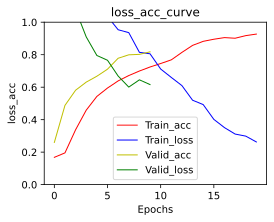

In [21]:
#LSTM(单向)训练集验证集损失和准确率图像
train1.show_loss_acc_value()

In [22]:
#LSTM(单向)加载
lstm1=torch.load('LSTM.pth')
lstm1 = lstm1.to(device)

In [33]:
#LSTM(双向)开始训练并验证
train2.start_train(train_loader,valid_loader ,val_idx = 2)

Start Training!
Train_set Epoch [0/20] loss: 2.1104559898376465, acc: 0.1657
Train_set Epoch [1/20] loss: 1.9765098094940186, acc: 0.1809
Start Validation!
Valid_set Epoch [1/10] loss: 1.925413966178894, acc: 0.2324
Best_model has been saved!
Stop Validation!
Train_set Epoch [2/20] loss: 1.798648715019226, acc: 0.2753
Train_set Epoch [3/20] loss: 1.659867525100708, acc: 0.2938
Start Validation!
Valid_set Epoch [2/10] loss: 1.6208168268203735, acc: 0.3072
Best_model has been saved!
Stop Validation!
Train_set Epoch [4/20] loss: 1.5154714584350586, acc: 0.3529
Train_set Epoch [5/20] loss: 1.3221570253372192, acc: 0.4174
Start Validation!
Valid_set Epoch [3/10] loss: 1.267122745513916, acc: 0.4414
Best_model has been saved!
Stop Validation!
Train_set Epoch [6/20] loss: 1.2122913599014282, acc: 0.4682
Train_set Epoch [7/20] loss: 1.146529197692871, acc: 0.53
Start Validation!
Valid_set Epoch [4/10] loss: 1.1659387350082397, acc: 0.5375
Best_model has been saved!
Stop Validation!
Train_set E

In [34]:
#LSTM(双向)加载
lstm2=torch.load('BiLSTM.pth')
lstm2 = lstm2.to(device)

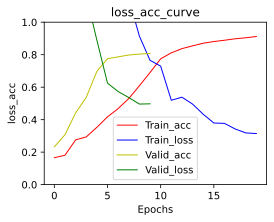

In [35]:
#LSTM(双向)训练集验证集损失和准确率图像
train2.show_loss_acc_value()

In [26]:
#定义LSTM模型评估函数
def LSTM_Evaluation(LSTM,valid_set):
    LSTM.eval()
    pred_list = []
    label_list = []
    hs = LSTM.init_hidden(batch_size)
    for idx, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        t_hat,hs = LSTM(x,hs)
        pred_list += torch.argmax(t_hat,axis = 1).cpu().tolist()
        label_list += t.cpu().tolist()
    f1 = f1_score(label_list, pred_list, average='macro')
    Accuracy_score = accuracy_score(label_list, pred_list)
    Recall_score = recall_score(label_list, pred_list,average='macro')
    print(f'Accuracy_score:{Accuracy_score}')
    print(f'Recall_score:{Recall_score}')
    print(f'f1_score:{f1}') 

In [27]:
#LSTM(单向)模型评估
LSTM_Evaluation(lstm1,valid_set)

Accuracy_score:0.8176800271739131
Recall_score:0.7535268606235399
f1_score:0.74817884050913


In [36]:
#LSTM(双向)模型评估
LSTM_Evaluation(lstm2,valid_set)

Accuracy_score:0.8077445652173914
Recall_score:0.7394249069692183
f1_score:0.7349844344083212
